In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [51]:
import pathlib

dataset_url = "file:///Users/andrewcarras/SpartaHack/mri_data.zip"
data_dir = tf.keras.utils.get_file('mri_data.zip', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')
#




155


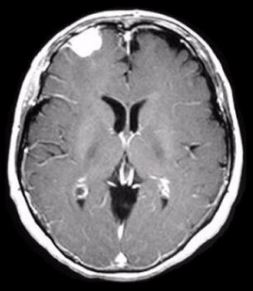

In [52]:
image_count = len(list(data_dir.glob('yes/*')))

print(image_count)

tumor = list(data_dir.glob('yes/*'))
PIL.Image.open(str(tumor[154]))

In [53]:
#Training 
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 253 files belonging to 2 classes.
Using 178 files for training.


In [54]:
#Validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 253 files belonging to 2 classes.
Using 75 files for validation.


In [55]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


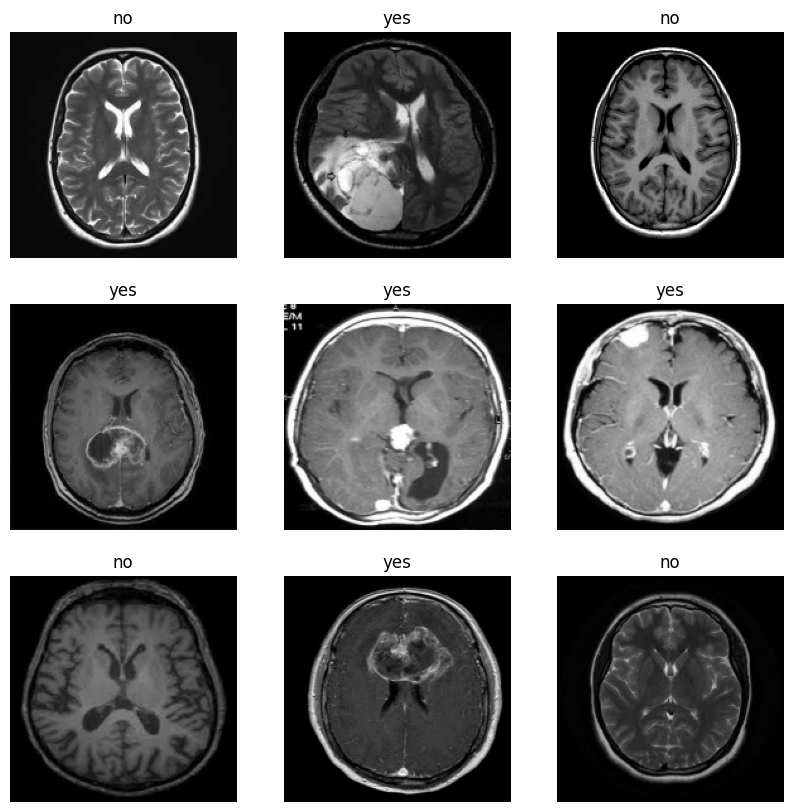

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [57]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [58]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [59]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9023652


In [60]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [61]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [63]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
6/6 [==============================] - 1s 98ms/step - loss: 1.1855 - accuracy: 0.5225 - val_loss: 0.5965 - val_accuracy: 0.7067
Epoch 2/10
6/6 [==============================] - 0s 80ms/step - loss: 0.4891 - accuracy: 0.7921 - val_loss: 0.5867 - val_accuracy: 0.7600
Epoch 3/10
6/6 [==============================] - 0s 81ms/step - loss: 0.4592 - accuracy: 0.8034 - val_loss: 0.6743 - val_accuracy: 0.7600
Epoch 4/10
6/6 [==============================] - 0s 81ms/step - loss: 0.4373 - accuracy: 0.7978 - val_loss: 0.6181 - val_accuracy: 0.7867
Epoch 5/10
6/6 [==============================] - 1s 93ms/step - loss: 0.4161 - accuracy: 0.8146 - val_loss: 0.6058 - val_accuracy: 0.7733
Epoch 6/10
6/6 [==============================] - 0s 82ms/step - loss: 0.3529 - accuracy: 0.8483 - val_loss: 0.6041 - val_accuracy: 0.7733
Epoch 7/10
6/6 [==============================] - 0s 82ms/step - loss: 0.2856 - accuracy: 0.8764 - val_loss: 0.6451 - val_accuracy: 0.7867
Epoch 8/10
6/6 [===========

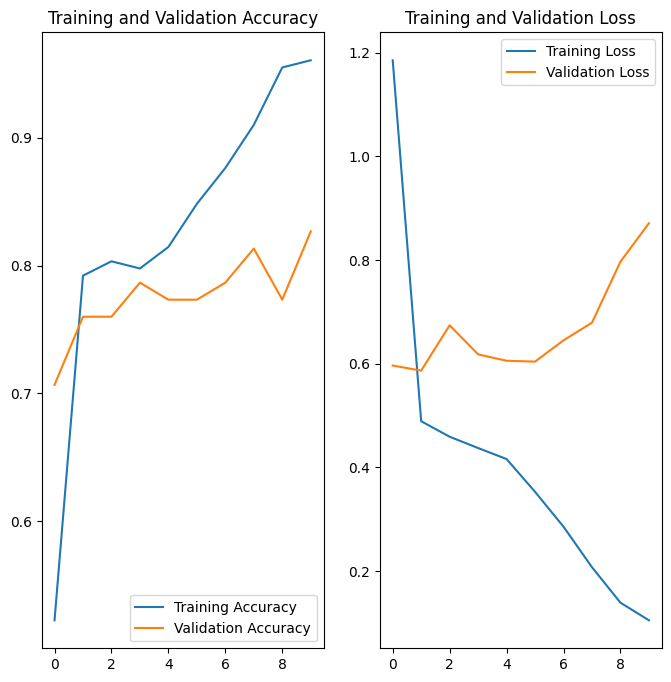

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [65]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

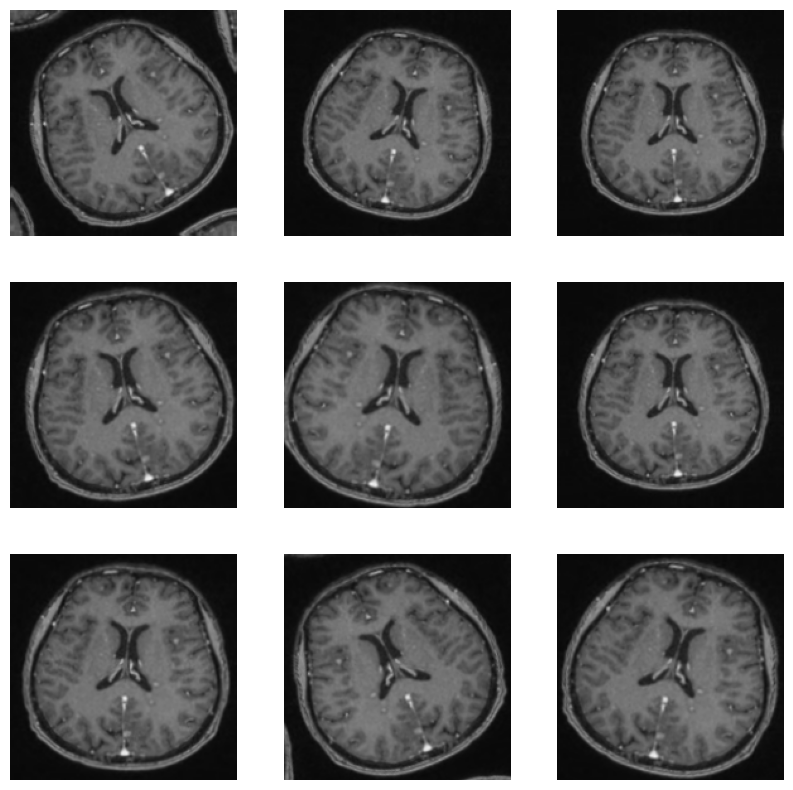

In [66]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [67]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [69]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),model.summary()
              metrics=['accuracy'])

In [70]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [71]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
6/6 [==============================] - 1s 97ms/step - loss: 0.7235 - accuracy: 0.5843 - val_loss: 0.6423 - val_accuracy: 0.6533
Epoch 2/15
6/6 [==============================] - 1s 91ms/step - loss: 0.5843 - accuracy: 0.7753 - val_loss: 0.5674 - val_accuracy: 0.7600
Epoch 3/15
6/6 [==============================] - 1s 93ms/step - loss: 0.4952 - accuracy: 0.7753 - val_loss: 0.6914 - val_accuracy: 0.7467
Epoch 4/15
6/6 [==============================] - 1s 89ms/step - loss: 0.5236 - accuracy: 0.7528 - val_loss: 0.6105 - val_accuracy: 0.7200
Epoch 5/15
6/6 [==============================] - 1s 93ms/step - loss: 0.4983 - accuracy: 0.7697 - val_loss: 0.5864 - val_accuracy: 0.7600
Epoch 6/15
6/6 [==============================] - 1s 92ms/step - loss: 0.5324 - accuracy: 0.7584 - val_loss: 0.5715 - val_accuracy: 0.7600
Epoch 7/15
6/6 [==============================] - 1s 97ms/step - loss: 0.5011 - accuracy: 0.7528 - val_loss: 0.6008 - val_accuracy: 0.7467
Epoch 8/15
6/6 [===========

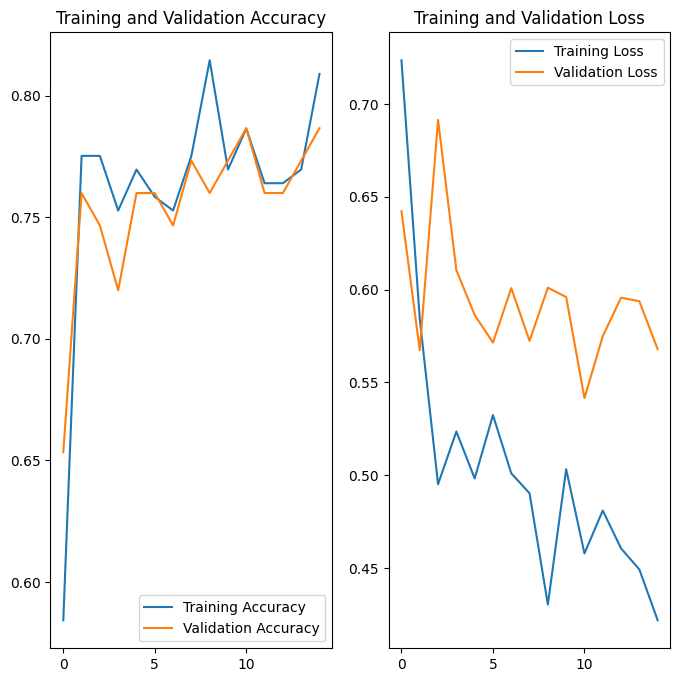

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [77]:

#dataset_url = "file:///Users/andrewcarras/SpartaHack/mri_data.zip"
new_mri_url = "file:///Users/andrewcarras/SpartaHack/new_mri/tumor.jpg"
new_mri_path = tf.keras.utils.get_file('tumor', origin=new_mri_url)

img = tf.keras.utils.load_img(
    new_mri_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 42ms/step
This image most likely belongs to yes with a 83.73 percent confidence.
